
# 0. Data collector
Data loader from ISIC

In [2]:
''' 
Load libs 
'''
import csv
import os
import json
import numpy as np
import pandas as pd

from concurrent.futures import ThreadPoolExecutor

## Make ISIC API requester

In [3]:

'''
Make ISIC Api request class
'''
import requests

class ISICApi(object):
    def __init__(self, hostname='https://isic-archive.com',
                 username=None, password=None):
        self.baseUrl = f'{hostname}/api/v1'
        self.authToken = None

        if username is not None:
            if password is None:
                password = input(f'Password for user "{username}":')
            self.authToken = self._login(username, password)

    def _makeUrl(self, endpoint):
        return f'{self.baseUrl}/{endpoint}'

    def _login(self, username, password):
        authResponse = requests.get(
            self._makeUrl('user/authentication'),
            auth=(username, password)
        )
        if not authResponse.ok:
            raise Exception(f'Login error: {authResponse.json()["message"]}')

        authToken = authResponse.json()['authToken']['token']
        return authToken

    def get(self, endpoint):
        url = self._makeUrl(endpoint)
        headers = {'Girder-Token': self.authToken} if self.authToken else None
        return requests.get(url, headers=headers)

    def getJson(self, endpoint):
        return self.get(endpoint).json()

    def getJsonList(self, endpoint):
        endpoint += '&' if '?' in endpoint else '?'
        LIMIT = 50
        offset = 0
        while True:
            resp = self.get(
                f'{endpoint}limit={LIMIT:d}&offset={offset:d}'
            ).json()
            if not resp:
                break
            for elem in resp:
                yield elem
            offset += LIMIT

## Get list of images names

In [4]:

#Insert Username and Password Below
api = ISICApi(username="veaxvoid", password="ZXCASD123qweasd")

limit = 400
offset = 0

image_list = api.getJson('image?limit={}&offset={}&sort=name'.format(limit, offset))
print('Requested {} images names'.format(len(image_list)))

Requested 400 images names


In [5]:
'''
Spesify output folders
'''
meta_dir = 'ISIC'
img_dir = meta_dir + '/images'
mask_dir = meta_dir + '/masks'
img_info_dir = meta_dir + '/info_images'
mask_info_dir = meta_dir + '/info_masks'
imgs_filename = 'imagedata'
mask_filename = 'masksdata'

if not os.path.exists(meta_dir): os.makedirs(meta_dir)
if not os.path.exists(img_dir): os.makedirs(img_dir)
if not os.path.exists(mask_dir): os.makedirs(mask_dir)
if not os.path.exists(img_info_dir): os.makedirs(img_info_dir)
if not os.path.exists(mask_info_dir): os.makedirs(mask_info_dir)

In [6]:
'''
Load info for each img
'''
def load_img_info(img_id, img_name):
    image_info = api.getJson('image/{}'.format(img_id))
    
    if image_info['dataset']['name'] != 'SONIC':
        file_path = os.path.join(img_info_dir, img_name+'.json')
        file = open(file_path, "w")
        json.dump(image_info, file)
        file.close()
    
imgs_id = [info['_id'] for info in image_list]
imgs_name = [info['name'] for info in image_list]

with ThreadPoolExecutor(12) as e: e.map(load_img_info, imgs_id, imgs_name)


In [7]:
'''
Collect all image info from json files in to csv table
'''
# read filenames in infoimages dir
infoimgs_filenames = sorted([f for f in os.listdir(img_info_dir)])

image_details = []

for img_name in infoimgs_filenames:
    file_path = os.path.join(img_info_dir, img_name)
    file = open(file_path, 'r')
    info = json.load(file)
    file.close()
    
    image_details += [info]

print('Number of valid images: {}'.format(len(image_details)))



Number of valid images: 400


In [8]:
'''
Image info to csv
'''
file_path = os.path.join(meta_dir, imgs_filename+'.csv')

# Determine the union of all image metadata fields
metadata_fields = set(
    field
    for image_detail in image_details
    for field in image_detail['meta']['clinical'].keys()
)
metadata_fields = ['isic_name','isic_id'] + sorted(metadata_fields) + ['dataset_name']

# Write the metadata to a CSV
print('Writing metadata to CSV: {}'.format(imgs_filename+'.csv'))

with open(file_path, 'w') as outputStream:
    csvWriter = csv.DictWriter(outputStream, metadata_fields)
    csvWriter.writeheader()
    
    for image_detail in image_details:
        row_dict = image_detail['meta']['clinical'].copy()
        row_dict['isic_name'] = image_detail['name']
        row_dict['isic_id'] = image_detail['_id']
        row_dict['dataset_name'] = image_detail['dataset']['name']
        csvWriter.writerow(row_dict)

Writing metadata to CSV: imagedata.csv


In [9]:

file_path = os.path.join(meta_dir, imgs_filename+'.csv')
data = pd.read_csv(file_path)

images_ids = list(data['isic_id'])
images_names = list(data['isic_name'])

data.tail()

,isic_name,isic_id,age_approx,anatom_site_general,benign_malignant,diagnosis,diagnosis_confirm_type,melanocytic,sex,dataset_name
395,ISIC_0000395,5436e3debae478396759f3e7,NaN,NaN,malignant,melanoma,histopathology,True,NaN,UDA-1
396,ISIC_0000396,5436e3debae478396759f3e9,NaN,NaN,benign,nevus,NaN,True,NaN,UDA-1
397,ISIC_0000397,5436e3debae478396759f3eb,NaN,NaN,benign,nevus,NaN,True,NaN,UDA-1
398,ISIC_0000398,5436e3dfbae478396759f3ed,NaN,NaN,malignant,melanoma,histopathology,True,NaN,UDA-1
399,ISIC_0000399,5436e3dfbae478396759f3ef,NaN,NaN,malignant,melanoma,histopathology,True,NaN,UDA-1


In [10]:

info_sum = {d:(data['diagnosis'] == d).sum() for d in data['diagnosis'].unique()}
print('Data summary:')
info_sum

Data summary:


{'nevus': 295, 'melanoma': 104, nan: 0}

## Load images

In [11]:
def load_imgs(img_id, img_name):
    img_file = api.get('image/{}/download'.format(img_id))
    img_file.raise_for_status()
    file_path = os.path.join(img_dir, '{}.png'.format(img_name))
  
    with open(file_path, 'wb') as out_stream:
        for chunk in img_file:
            out_stream.write(chunk)
    
with ThreadPoolExecutor(12) as e: e.map(load_imgs, images_ids, images_names)

## Load segmentation masks

In [12]:

# load segmentation data

def load_mask_info(img_id, img_name):
    segmentation_data = api.getJson('segmentation?imageId={}'.format(img_id))
    
    file_path = os.path.join(mask_info_dir, img_name+'.json')
    file = open(file_path, "w")
    json.dump(segmentation_data, file)
    file.close()
    
with ThreadPoolExecutor(12) as e: e.map(load_mask_info, images_ids, images_names)

# 0.1. Data splitter.ipynb

In [13]:
'''
collect all masks info from json files 
'''
segmentation_details = []

for img_name in images_names:
    file_path = os.path.join(mask_info_dir, img_name+'.json')
    file = open(file_path, 'r')
    info = json.load(file)
    file.close()
    
    if info:
        segmentation_details += [info[0]]

print('Number of segmentation info files: {}'.format(len(segmentation_details)))

Number of segmentation info files: 400


In [14]:
'''
Masks info to csv
'''

file_path = os.path.join(meta_dir, mask_filename+'.csv')

# Determine the union of all image metadata fields
metadata_fields = set(
    segmentation_details[0].keys()
)

metadata_fields = ['isic_id'] + sorted(metadata_fields)

# Write the metadata to a CSV
print('Writing metadata to CSV: {}'.format(mask_filename+'.csv'))

with open(file_path, 'a') as outputStream:
    csvWriter = csv.DictWriter(outputStream, metadata_fields)
    csvWriter.writeheader()
    
    k=-1
    for info in segmentation_details:
        k+=1
        row_dict = info.copy()
        row_dict['isic_id'] = images_names[k]
        csvWriter.writerow(row_dict)

Writing metadata to CSV: masksdata.csv


In [15]:

data = pd.read_csv(file_path)

print('Number of novice level masks: {} from {}'.format( (data['skill'] == 'novice').sum(), data['_id'].size ))

Number of novice level masks: 4 from 801


In [16]:
def load_mask(mask_id, img_name):
    img_file = api.get('segmentation/{}/mask'.format(mask_id))
    img_file.raise_for_status()
    file_path = os.path.join(mask_dir, '{}_mask.png'.format(img_name))

    with open(file_path, 'wb') as out_stream:
        for chunk in img_file:
            out_stream.write(chunk)    
            
masks_names = list(data['isic_id'])
masks_id = list(data['_id'])

with ThreadPoolExecutor(12) as e: e.map(load_mask, masks_id, masks_names)

In [17]:
''' 
Load libs 
'''
import os, shutil
import pandas as pd

In [18]:

'''
Spesify folders
'''
original_dataset_dir = 'ISIC'
original_images_dir = os.path.join(original_dataset_dir, 'images')
original_masks_dir = os.path.join(original_dataset_dir, 'masks')

base_dir = 'data'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')


train_images_dir = os.path.join(train_dir, 'images')
train_masks_dir = os.path.join(train_dir, 'masks')

validation_images_dir = os.path.join(validation_dir, 'images')
validation_masks_dir = os.path.join(validation_dir, 'masks')

test_images_dir = os.path.join(test_dir, 'images')
test_masks_dir = os.path.join(test_dir, 'masks')

In [19]:
'''
Create folders
'''
def mkdir(dir_path): 
    if not os.path.exists(dir_path): os.makedirs(dir_path)

mkdir(base_dir)

mkdir(train_dir)
mkdir(validation_dir)
mkdir(test_dir)

mkdir(train_images_dir)
mkdir(train_masks_dir)
mkdir(validation_images_dir)
mkdir(validation_masks_dir)
mkdir(test_images_dir)
mkdir(test_masks_dir)

In [24]:

'''
Get names of images and masks with split
'''
split = {'train':0.7, 'validation':0.1, 'test':0.2} # must sumup to 1

masksinfo_file_path = os.path.join(original_dataset_dir, 'masksdata.csv')
masks_info = pd.read_csv(masksinfo_file_path)
print(type(masks_info))
images_names = list(masks_info['isic_id'])
# masks_filenames = [name+'_mask' for name in images_names] 

train_split = int(len(images_names) * split['train'])
validation_split = int(len(images_names) * split['validation'])
test_split = int(len(images_names) * split['test'])

train_images_filenames = images_names[:train_split]
validation_images_filenames = images_names[train_split:train_split+validation_split]
test_images_filenames = images_names[train_split+validation_split:]

print('Total images:     {}'.format(len(images_names)))
print('Train split:      {}'.format(len(train_images_filenames)))
print('Validation split: {}'.format(len(validation_images_filenames)))
print('Test split:       {}'.format(len(test_images_filenames)))
print('-'*23)
print('Split sum:        {}'.format(len(train_images_filenames)+len(validation_images_filenames)+len(test_images_filenames)))

<class 'pandas.core.frame.DataFrame'>
Total images:     801
Train split:      560
Validation split: 80
Test split:       161
-----------------------
Split sum:        801


In [37]:

'''
Copy images and masks into the folders
'''
# Copy train images and masks
for image_name in train_images_filenames:
    if image_name!='isic_id':
        src_img = os.path.join(original_images_dir, image_name+'.png')
        dst_img = os.path.join(train_images_dir, image_name+'.png')
    
        src_mask = os.path.join(original_masks_dir, image_name+'_mask.png')
        dst_mask = os.path.join(train_masks_dir, image_name+'_mask.png')
    
        shutil.copyfile(src_img, dst_img) 
        shutil.copyfile(src_mask, dst_mask) 
    
# Copy validation images and masks
for image_name in validation_images_filenames:
    #print(image_name)
    if image_name!='isic_id':
        src_img = os.path.join(original_images_dir, image_name+'.png')
        dst_img = os.path.join(validation_images_dir, image_name+'.png')  
        src_mask = os.path.join(original_masks_dir, image_name+'_mask.png')
        dst_mask = os.path.join(validation_masks_dir, image_name+'_mask.png')
        #print(image_name)
        #shutil.copyfile(src_img, dst_img)
        #shutil.copyfile(src_mask, dst_mask) 
# Copy test images and masks
for image_name in test_images_filenames:
    src_img = os.path.join(original_images_dir, image_name+'.png')
    dst_img = os.path.join(test_images_dir, image_name+'.png')
    
    src_mask = os.path.join(original_masks_dir, image_name+'_mask.png')
    dst_mask = os.path.join(test_masks_dir, image_name+'_mask.png')
    
    shutil.copyfile(src_img, dst_img) 
    shutil.copyfile(src_mask, dst_mask) 

print('Done')

Done


In [164]:
print('Total training images:   {}'.format(len(os.listdir(train_images_dir))))
print('Total training masks:    {}'.format(len(os.listdir(train_masks_dir))))
print('Total validation images: {}'.format(len(os.listdir(validation_images_dir))))
print('Total validation masks:  {}'.format(len(os.listdir(validation_masks_dir))))
print('Total test images:       {}'.format(len(os.listdir(test_images_dir))))
print('Total test masks:        {}'.format(len(os.listdir(test_masks_dir))))

NameError: name 'os' is not defined

# 2. Feature extraction
## ABC Feature extractor

In [3]:

import matplotlib.pyplot as plt
from skimage import io
import numpy as np

# load test image and mask
img = io.imread('ISIC/images/ISIC_0000021.png')
mask = (io.imread('ISIC/masks/ISIC_0000021_mask.png') / 255).astype(int)
plt.imshow(img, vmin=0,vmax=255)
# plt.imshow(mask, alpha=0.3)
plt.show()

mask = mask.reshape(mask.shape[0], mask.shape[1], 1)

<Figure size 640x480 with 1 Axes>

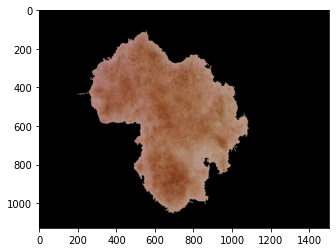

In [4]:
crop_img = img * mask
plt.imshow(crop_img)
plt.show()

## A - Asymmetry

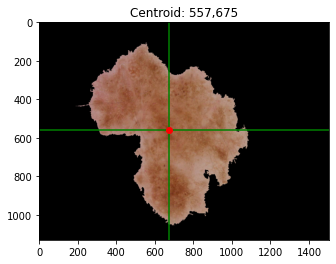

In [5]:
import cv2
'''
Find center of melanoma
'''
# [pix for pix in crop_img.sum(2) if pix > 0]

center = [0,0]
c_img = crop_img.sum(2)
count = np.sum(c_img > 0)
##### I changed this and the rest of the code to [y,x],so y will always be first and x will be second
####sorry for the inconvevience
for y in range(c_img.shape[0]):
    for x in range(c_img.shape[1]):
        if c_img[y,x] != 0:
            center[1] += x
            center[0] += y

center = (center / count).astype(int)

plt.imshow(crop_img)

plt.plot([center[1],center[1]], 
         [0,crop_img.shape[0]], 
         '-g')
plt.plot([0,crop_img.shape[1]], 
         [center[0],center[0]],
         '-g')
##seems like plt.plot is x,y though, shouldn't had switched things around orz
plt.plot(center[1], center[0], 'or')
plt.title('Centroid: {},{}'.format(center[0],center[1]))
plt.xlim(0,crop_img.shape[1])
plt.ylim(crop_img.shape[0], 0)
plt.show()


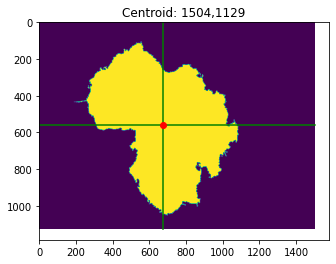

[572 829]


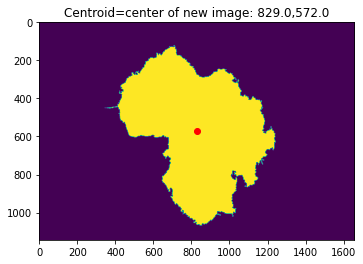

In [6]:
mask = cv2.imread('ISIC/masks/ISIC_0000021_mask.png', 0)
# print(mask.shape)
# print(np.unique(mask))
plt.plot([center[1],center[1]], 
         [0,crop_img.shape[0]], 
         '-g')
plt.plot([0,crop_img.shape[1]], 
         [center[0],center[0]],
         '-g')

plt.plot(center[1], center[0], 'or')
plt.title('Centroid: {},{}'.format(mask.shape[1],mask.shape[0]))

plt.imshow(mask)
plt.show()

##parts I added to place sum center at image(mask) center
##zero padding to make mass center the same as image center for the new mask
if mask.shape[1]-center[1]<=center[1] and mask.shape[0]-center[0]>=center[0]:##zero padding top right corner
    new_mask = np.zeros([(mask.shape[0]-center[0])*2,center[1]*2])
    new_mask[mask.shape[0]-center[0]*2:mask.shape[0]*2-center[0]*2,0:mask.shape[1]]=mask
    #new_mask = mask[mask.shape[0]-center[0]*2:mask.shape[0]-center[0],0:center[1]*2] / 255
elif mask.shape[1]-center[1]>=center[1] and mask.shape[0]-center[0]>=center[0]:##zero padding top left corner
    new_mask = np.zeros([(mask.shape[0]-center[0])*2,(mask.shape[1]-center[1])*2])
    new_mask[mask.shape[0]-center[0]*2:mask.shape[0]*2-center[0]*2,mask.shape[1]-center[1]*2:mask.shape[1]*2-center[1]*2]=mask
elif mask.shape[1]-center[1]<=center[1] and mask.shape[0]-center[0]<=center[0]:##zero padding bottom right corner
    new_mask = np.zeros([center[0]*2,center[1]*2])
    new_mask[0:mask.shape[0],0:mask.shape[1]]=mask
else:##zero padding top right corner
    new_mask = np.zeros([center[0]*2,(mask.shape[1]-center[1])*2])
    new_mask[0:mask.shape[0],mask.shape[1]-center[1]*2:mask.shape[1]*2-center[1]*2]=mask
plt.imshow(new_mask)
plt.plot(new_mask.shape[1]/2,new_mask.shape[0]/2, 'or')
plt.title('Centroid=center of new image: {},{}'.format(new_mask.shape[1]/2,new_mask.shape[0]/2))
new_center = [0,0]
for y in range(new_mask.shape[0]):
    for x in range(new_mask.shape[1]):
        if new_mask[y,x] != 0:
            new_center[1] += x
            new_center[0] += y
new_center = (new_center / count).astype(int)
print(new_center)##doublecheck answer


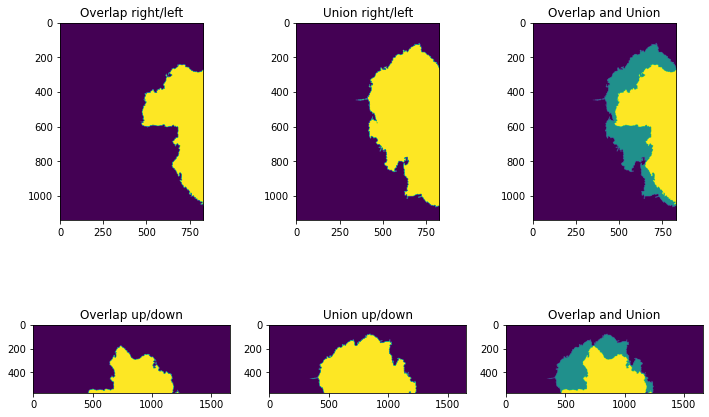

In [7]:
# get symmetry parts
right = new_mask[:,:new_center[1]] / 255
left = cv2.flip(new_mask[:,new_center[1]:], 1) / 255
up =  new_mask[:new_center[0],:] / 255
down = cv2.flip(new_mask[new_center[0]:,:], 0) / 255

# normilizing
if right.shape[1] > left.shape[1]:
    zz = np.zeros((right.shape[0],right.shape[1]-left.shape[1]))
    left = np.concatenate((zz,left), axis=1)
else:
    zz = np.zeros((left.shape[0],left.shape[1]-right.shape[1]))
    right = np.concatenate((zz,right), axis=1)

if up.shape[0] > down.shape[0]:
    zz = np.zeros((up.shape[0] - down.shape[0], up.shape[1]))
    down = np.concatenate((zz,down), axis=0)
else:
    zz = np.zeros((down.shape[0] - up.shape[0], down.shape[1]))
    up = np.concatenate((zz,up), axis=0)

vertical_union = right * left
vectical_overlap = (right + left > 0).astype(int)

horisontal_union = up * down
horisontal_overlap = (up + down > 0).astype(int) 

fig, ax = plt.subplots(2,3, figsize=(12,8))

ax[0,0].imshow(vertical_union)
ax[0,0].set_title('Overlap right/left')
ax[0,1].imshow(vectical_overlap)
ax[0,1].set_title('Union right/left')
ax[0,2].imshow(vectical_overlap + vertical_union)
ax[0,2].set_title('Overlap and Union')

ax[1,0].imshow(horisontal_union)
ax[1,0].set_title('Overlap up/down')
ax[1,1].imshow(horisontal_overlap)
ax[1,1].set_title('Union up/down')
ax[1,2].imshow(horisontal_overlap + horisontal_union)
ax[1,2].set_title('Overlap and Union')
plt.show()

In [8]:
#print(type(mask))
#alpha = 89
#tan_alpha = np.tan(np.deg2rad(alpha))
# Calculate tangent of rotation angle
#print(tan_alpha)
# Calculate first edge point
#y0 = np.int32(center[0] - center[1] / tan_alpha)
#if y0 < 0:
#    y0 = 0
#    x0 = np.int32(-center[0] * tan_alpha + center[1])
#else:
#    x0 = 0
# Calculate second edge point
#y1 = np.int32(center[0] + (mask.shape[0] - center[1]) / tan_alpha)
#if y1 > mask.shape[1]:
#    y1 = mask.shape[1]
#    x1 = np.int32((x1 - center[0]) * tan_alpha + center[1])
#else:
#    x1 = mask.shape[0]
#plt.plot(x1, y1, 'or')
#print(x1)
#print(y1)
#plt.plot(center[1], center[0], 'or')
#plt.plot(x0, y0, 'or')
#plt.plot([x1,x0], 
#         [y1,y0], 
#         '-g')
#plt.imshow(mask)
#plt.show()

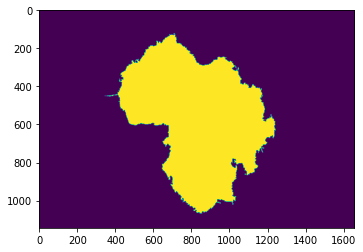

In [9]:
##rotate angle function (to avoid cropping)
def rotate_image(mat, angle):
    """
    Rotates an image (angle in degrees) and expands image to avoid cropping
    """

    height, width = mat.shape[:2] # image shape has 3 dimensions
    image_center = (width/2, height/2) # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0,0]) 
    abs_sin = abs(rotation_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    # rotate image with the new bounds and translated rotation matrix
    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))
    return rotated_mat
mask2=rotate_image(new_mask,30)
plt.imshow(new_mask)

In [10]:
###testing out rotation
#rotate_count = np.sum(mask2 > 0)
#rotate_center=[0,0] 
#for y in range(mask2.shape[0]):
#    for x in range(mask2.shape[1]):
#        if mask2[y,x] != 0:
#            rotate_center[1] += x
#            rotate_center[0] += y
#rotate_center = (rotate_center / rotate_count).astype(int)

#plt.plot([rotate_center[1],rotate_center[1]], 
#         [0,mask2.shape[0]], 
#         '-g')
#plt.plot([0,mask2.shape[1]], 
#         [rotate_center[0],rotate_center[0]],
#         '-g')

#plt.plot(mask2.shape[1]/2,mask2.shape[0]/2, 'or')
#plt.title('Centroid: {},{}'.format(mask2.shape[1],mask2.shape[0]))

#plt.imshow(mask2)
#plt.show()

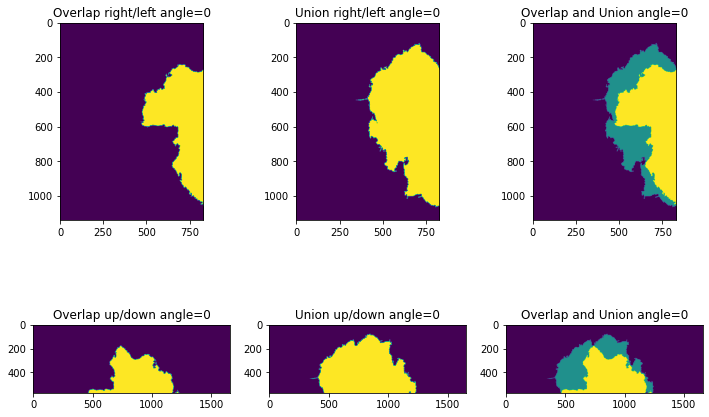

Vertical symmetry:   0.5744958161134396
Horisontal symmetry: 0.525593587276432
-------------------------
Total symmetry: 0.5500447016949358


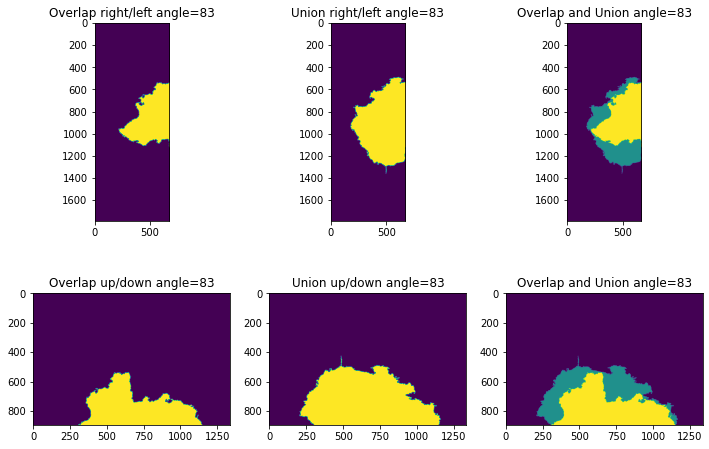

Vertical symmetry:   0.564932359536
Horisontal symmetry: 0.5791455954342624
-------------------------
Total symmetry: 0.5720389774851311


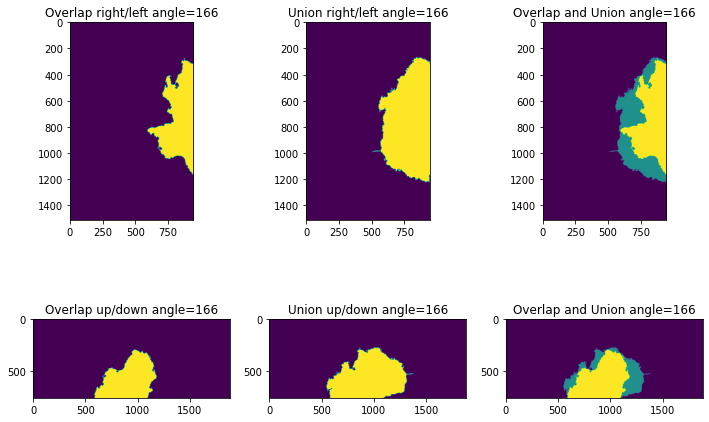

Vertical symmetry:   0.5675380056818015
Horisontal symmetry: 0.6670212986836328
-------------------------
Total symmetry: 0.6172796521827171


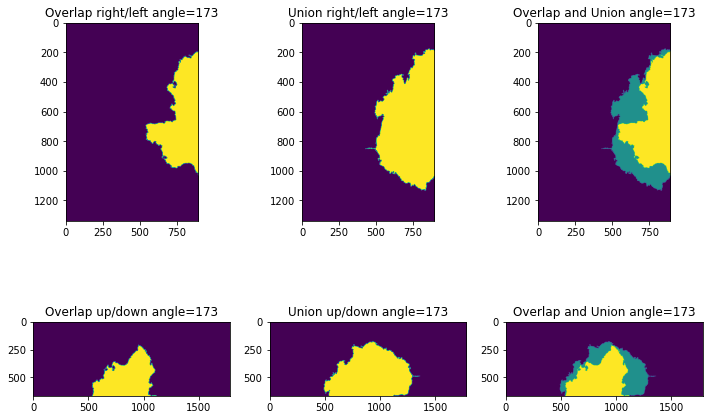

Vertical symmetry:   0.5791483165290015
Horisontal symmetry: 0.5670651524159319
-------------------------
Total symmetry: 0.5731067344724667


In [11]:
max_vangle=-1 ##angle of max vertical symmetry (degrees)
max_vsymmetry=-1  ##value of max vertical symmetry
max_tangle=-1 ##angle of max total symmetry
max_tsymmetry=-1
for angle in range(180):##since 180 is just the original one fliped around we only need 0-179 
    rotate_mask=rotate_image(new_mask,angle)
    right = rotate_mask[:,:int(rotate_mask.shape[1]/2)] / 255
    left = cv2.flip(rotate_mask[:,int(rotate_mask.shape[1]/2):], 1) / 255
    up =  rotate_mask[:int(rotate_mask.shape[0]/2),:] / 255
    down = cv2.flip(rotate_mask[int(rotate_mask.shape[0]/2):,:], 0) / 255

    # normilizing
    if right.shape[1] > left.shape[1]:
        zz = np.zeros((right.shape[0],right.shape[1]-left.shape[1]))
        left = np.concatenate((zz,left), axis=1)
    else:
        zz = np.zeros((left.shape[0],left.shape[1]-right.shape[1]))
        right = np.concatenate((zz,right), axis=1)

    if up.shape[0] > down.shape[0]:
        zz = np.zeros((up.shape[0] - down.shape[0], up.shape[1]))
        down = np.concatenate((zz,down), axis=0)
    else:
        zz = np.zeros((down.shape[0] - up.shape[0], down.shape[1]))
        up = np.concatenate((zz,up), axis=0)

    vertical_union = right * left
    vectical_overlap = (right + left > 0).astype(int)

    horisontal_union = up * down
    horisontal_overlap = (up + down > 0).astype(int) 
    
    
    # 0 - assymetric; 1 - symmetric
    vertical_symmetry = (vertical_union.sum() / vectical_overlap.sum())
    horisontal_symmetry = (horisontal_union.sum() / horisontal_overlap.sum())
    total_symmetry = (vertical_symmetry + horisontal_symmetry) / 2
    if vertical_symmetry>max_vsymmetry:
        max_vsymmetry=vertical_symmetry
        max_vangle=angle
    if total_symmetry>max_tsymmetry:
        max_tsymmetry=total_symmetry
        max_tangle=angle
    
    if angle%83==0 or angle%173==0 :
        fig, ax = plt.subplots(2,3, figsize=(12,8))

        ax[0,0].imshow(vertical_union)
        ax[0,0].set_title('Overlap right/left angle={}'.format(angle))
        ax[0,1].imshow(vectical_overlap)
        ax[0,1].set_title('Union right/left angle={}'.format(angle))
        ax[0,2].imshow(vectical_overlap + vertical_union)
        ax[0,2].set_title('Overlap and Union angle={}'.format(angle))

        ax[1,0].imshow(horisontal_union)
        ax[1,0].set_title('Overlap up/down angle={}'.format(angle))
        ax[1,1].imshow(horisontal_overlap)
        ax[1,1].set_title('Union up/down angle={}'.format(angle))
        ax[1,2].imshow(horisontal_overlap + horisontal_union)
        ax[1,2].set_title('Overlap and Union angle={}'.format(angle))
        plt.show()
        print('Vertical symmetry:   {}'.format(vertical_symmetry))
        print('Horisontal symmetry: {}'.format(horisontal_symmetry))
        print('-'*25)
        print('Total symmetry: {}'.format(total_symmetry))
##remarks, it's not that accurate though, seeing vertical of 83 should equal horizonal of 173(+90)...
##0.2% difference is spotted for the difference between the supposely same value

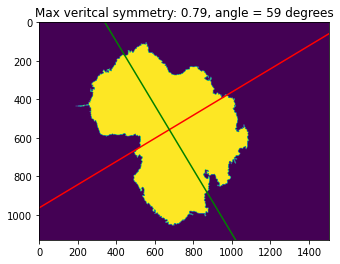

In [12]:
x = np.linspace(0, mask.shape[1], 1000)
plt.imshow(mask)
plt.plot(x,(x-center[1])*np.tan(np.deg2rad(max_vangle+90))+center[0], '-r')##vertical line is red
plt.plot(x,(x-center[1])*np.tan(np.deg2rad(max_vangle))+center[0], '-g')##horizontal line is green
plt.title('Max veritcal symmetry: {:2.2f}, angle = {} degrees'.format(max_vsymmetry,max_vangle))
##angle is the value of the horizontal line though
plt.xlim(0,mask.shape[1])
plt.ylim(mask.shape[0], 0)
plt.show()

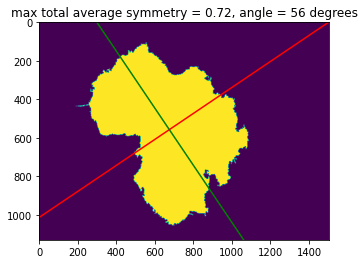

In [13]:
plt.imshow(mask)
plt.plot(x,(x-center[1])*np.tan(np.deg2rad(max_tangle+90))+center[0], '-r')##vertical line is red
plt.plot(x,(x-center[1])*np.tan(np.deg2rad(max_tangle))+center[0], '-g')##horizontal line is green
plt.title('max total average symmetry = {:2.2f}, angle = {} degrees'.format(max_tsymmetry,max_tangle))
##angle is the value of the horizontal line though
plt.xlim(0,mask.shape[1])
plt.ylim(mask.shape[0], 0)
plt.show()
##total and vertical is the same...coincidence???? 

## B - Border Irregularity
### Compactness index

In [14]:
from skimage.measure import label, regionprops
from skimage import feature
import math
#im = io.imread('1593996968039.jpg')##circle test,try circle.png and square.png  
#im = io.imread('circle.png')
#bw = im[:,:,0] > 230
#plt.imshow(bw)
regions = regionprops(mask.astype(int))
print('Perimeter: {:2.2f}'.format(regions[0].perimeter))
print('Area: {:2.2f}'.format(regions[0].area))
Cl=(regions[0].perimeter)**2/(4*3.1415926535*regions[0].area)
print('Compactness index: {:2.2f}'.format(Cl))
##very sensitive to noise along the boarder, even a circle is around 1.108 something, though square has much less distortion
##this example should be 7.8

Perimeter: 5284.32
Area: 431267.00
Compactness index: 5.15


### Edge Abruptness

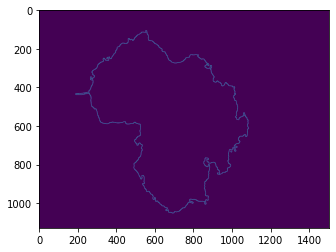

In [15]:
#print(type(bw))
#print(type(mask))
#bw= (bw).astype('uint8')
#print(type(bw))
##edge dection, for iterating through the edge later on
edge=feature.canny(mask,sigma=3)
plt.imshow(edge)
##somehow images like circle.png and 1593996968039.jpg doesn't work here, not sure why


In [16]:
regions2 = regionprops(edge.astype(int))
print('Perimeter: {:2.2f}'.format(regions2[0].perimeter))
print('Area: {:2.2f}'.format(regions2[0].area))


import statistics 
count=0;
edgepoints=[];
for y in range(mask.shape[0]):
    for x in range(mask.shape[1]):
        if edge[y,x] != 0:
            count=count+1
            edgepoints.append(float((x-center[1])**2+(y-center[0])**2)**0.5)
mn = statistics.mean(edgepoints) 
ea = statistics.pvariance(edgepoints, mn)*count/(regions[0].perimeter*mn**2)#edge abruptness
print('Edge Abruptness: {:2.3f}'.format(ea))

Perimeter: 5093.66
Area: 4936.00
Edge Abruptness: 0.038


## C - Color

(1698016, 3)

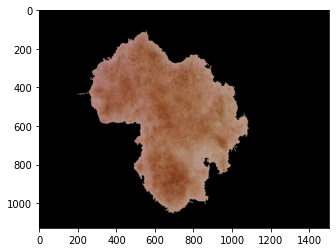

In [17]:
from scipy import ndimage
from sklearn import cluster
#crop_img.shape

x, y, z = crop_img.shape
plt.imshow(crop_img)
crop_img_2d = crop_img.reshape(x*y, z)
crop_img_2d.shape

In [18]:
kmeans_cluster = cluster.KMeans(n_clusters=7)##it is 7 since 1 color is reserved for the background? 
kmeans_cluster.fit(crop_img_2d)
cluster_centers = kmeans_cluster.cluster_centers_
cluster_labels = kmeans_cluster.labels_

(1129, 1504, 3)

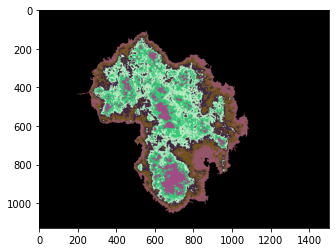

In [19]:
plt.imshow((cluster_centers[cluster_labels].reshape(x, y, z)* 255).astype(np.uint8))
cluster_centers[cluster_labels].reshape(x, y, z).shape